Status: Optimal
Optimal Solution:
Hour 0: Power Input = 0.0, Power Output = 0.0, SOC = 0.0
Hour 1: Power Input = 250.0, Power Output = 0.0, SOC = 250.0
Hour 2: Power Input = 0.0, Power Output = 32.0, SOC = 218.0
Hour 3: Power Input = 0.0, Power Output = 31.0, SOC = 187.0
Hour 4: Power Input = 0.0, Power Output = 31.0, SOC = 156.0
Hour 5: Power Input = 0.0, Power Output = 31.0, SOC = 125.0
Hour 6: Power Input = 125.0, Power Output = 0.0, SOC = 250.0
Hour 7: Power Input = 0.0, Power Output = 57.0, SOC = 193.0
Hour 8: Power Input = 0.0, Power Output = 76.0, SOC = 117.0
Hour 9: Power Input = 0.0, Power Output = 117.0, SOC = 0.0
Hour 10: Power Input = 250.0, Power Output = 0.0, SOC = 250.0
Hour 11: Power Input = 0.0, Power Output = 155.0, SOC = 95.0
Hour 12: Power Input = 0.0, Power Output = 95.0, SOC = 0.0
Hour 13: Power Input = 198.0, Power Output = 0.0, SOC = 198.0
Hour 14: Power Input = 0.0, Power Output = 90.0, SOC = 108.0
Hour 15: Power Input = 0.0, Power Output = 108.0, SOC = 0.0
Hou

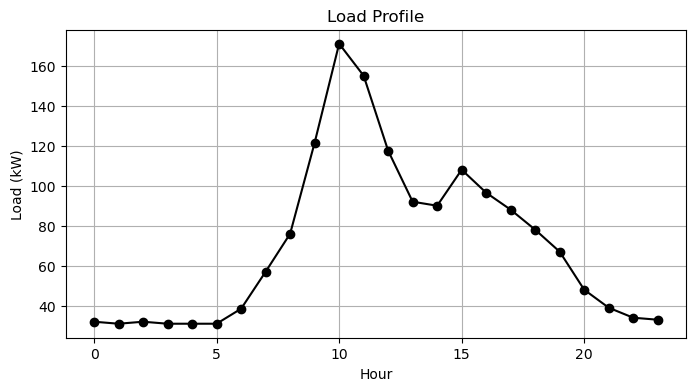

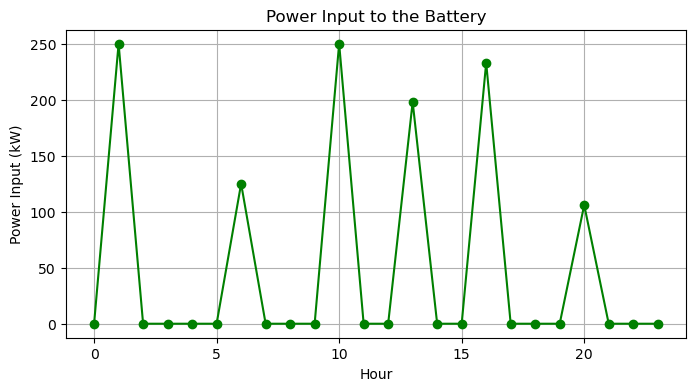

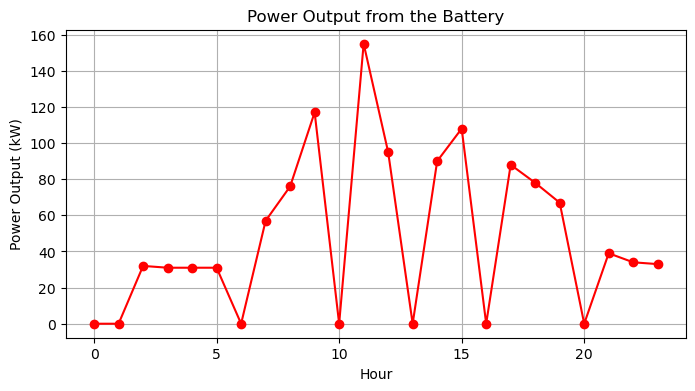

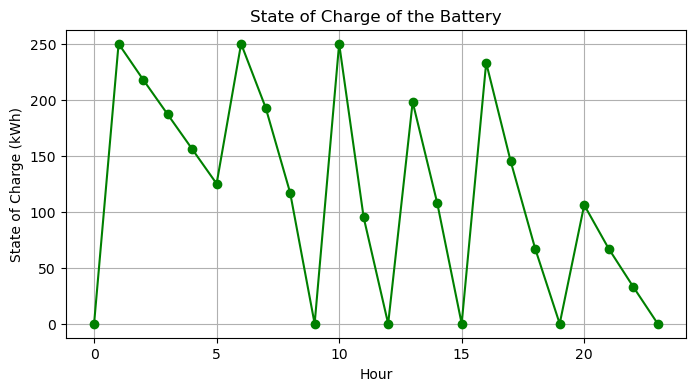

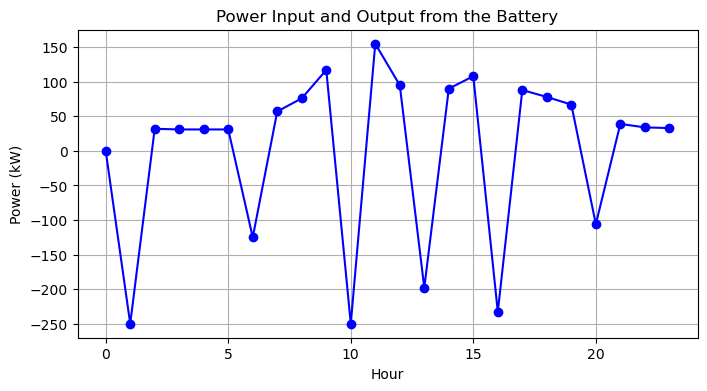

Total Energy Provided to the Load by the battery: 1162.0 kWh
Total Energy Demanded by the Load: 1698.0 kWh
Percentage of energy supplied by the battery: 68.43345111896349 %
The signal to the Hybridization model is: [0.0, -250.0, 32.0, 31.0, 31.0, 31.0, -125.0, 57.0, 76.0, 117.0, -250.0, 155.0, 95.0, -198.0, 90.0, 108.0, -233.0, 88.0, 78.0, 67.0, -106.0, 39.0, 34.0, 33.0]


In [11]:
#This script is an optimization to maximize the energy that the battery charges and discharges for supplying energy to a load.
#It produces a plot that will serve as the input signal for the hybridization model!


import matplotlib.pyplot as plt
from pulp import *

# Load profile  - Vem do exercicio de clusterização para encontrar o padrão recorrente usando o DTW
load = [32.0, 31.0, 32.0, 31.0, 31.0, 31.0, 38.5, 57.0, 76.0, 121.5, 171.0, 155.0, 117.5, 92.0, 90.0, 108.0, 96.5, 88.0, 78.0, 67.0, 48.0, 39.0, 34.0, 33.0]

# Definir tamanho da bateria original
Max_energy=250 #É o ponto da curva da ultima figura onde não há mais ganho marginal na % em que a bateria abastece carga
Max_Power=250 # Its the maximum of the box plots. C-Rate 0.5 seria 500 kWh 

# Problem Statement
problem = LpProblem("Battery Optimization", LpMaximize)

# Define variables
hours = range(24)  # 24 hours in a day
power_in = LpVariable.dicts("Power_in", hours, lowBound=0, upBound=Max_Power)  # Power input to the battery in each hour
power_out = LpVariable.dicts("Power_out", hours, lowBound=0, upBound=Max_Power)  # Power output from the battery in each hour
energy_in = LpVariable.dicts("Energy_in", hours, lowBound=0, upBound=Max_energy)  # Energy charged by the battery in each hour
energy_out = LpVariable.dicts("Energy_out", hours, lowBound=0, upBound=Max_energy)  # Energy discharged by the battery in each hour
soc = LpVariable.dicts("SOC", hours, lowBound=0, upBound=Max_energy)  # State of charge of the battery at the end of each hour
charge_discharge = LpVariable.dicts("Charge_Discharge", hours, cat='Binary')  # Binary variable representing charging or discharging

# Objective function
problem += lpSum(energy_in[hour] for hour in hours)  # Maximize the sum of energy input

# Constraints
for hour in hours:
    # Energy balance constraint
    if hour == 0:
        problem += soc[hour] == energy_in[hour] - energy_out[hour]  # Battery starts the day with zero energy
    else:
        problem += soc[hour] == soc[hour-1] + energy_in[hour] - energy_out[hour]  # Energy at the end of the hour
    
    problem += power_in[hour] == energy_in[hour]  # Assuming 1 hour time step
    problem += power_out[hour] == energy_out[hour]  # Assuming 1 hour time step
    
    # Power capacity constraint
    problem += power_in[hour] <= Max_Power  # Maximum power input of 100 kW
    problem += power_out[hour] <= Max_Power  # Maximum power output of 100 kW
    
    # Energy capacity constraint
    problem += energy_in[hour] <= Max_energy  # Maximum energy capacity of 140 kWh
    problem += energy_out[hour] <= Max_energy  # Maximum energy capacity of 140 kWh

    # Additional constraint to prevent charging and discharging at the same time
    problem += energy_in[hour] <= charge_discharge[hour] * Max_energy
    problem += energy_out[hour] <= (1 - charge_discharge[hour]) * Max_energy

# Add load constraints
for hour in hours:
    problem += power_out[hour] <= load[hour]  # Power output cannot exceed the load demand

# Add constraint for SOC to be zero at the beginning of the day
problem += soc[0] == 0
problem += soc[23] == 0
# Solve the problem
problem.solve()

# Print the result
print("Status:", LpStatus[problem.status])
print("Optimal Solution:")
for hour in hours:
    print(f"Hour {hour}: Power Input = {power_in[hour].varValue}, Power Output = {power_out[hour].varValue}, SOC = {soc[hour].varValue}")

# Plot load profile
plt.figure(figsize=(8, 4))
plt.plot(hours, load, marker='o', linestyle='-', color='k')
plt.xlabel('Hour')
plt.ylabel('Load (kW)')
plt.title('Load Profile')
plt.grid(True)
plt.show()

# Plot power input to the battery
power_in_values = [power_in[hour].varValue for hour in hours]
plt.figure(figsize=(8, 4))
plt.plot(hours, power_in_values, marker='o', linestyle='-', color='g')
plt.xlabel('Hour')
plt.ylabel('Power Input (kW)')
plt.title('Power Input to the Battery')
plt.grid(True)
plt.show()

# Plot power output from the battery
power_out_values = [power_out[hour].varValue for hour in hours]
plt.figure(figsize=(8, 4))
plt.plot(hours, power_out_values, marker='o', linestyle='-', color='r')
plt.xlabel('Hour')
plt.ylabel('Power Output (kW)')
plt.title('Power Output from the Battery')
plt.grid(True)
plt.show()

# Plot state of charge (SOC) of the battery
soc_values = [soc[hour].varValue for hour in hours]
plt.figure(figsize=(8, 4))
plt.plot(hours, soc_values, marker='o', linestyle='-', color='g')
plt.xlabel('Hour')
plt.ylabel('State of Charge (kWh)')
plt.title('State of Charge of the Battery')
plt.grid(True)
plt.show()
power_difference = [-power_in[hour].varValue + power_out[hour].varValue for hour in hours]

# Plot the difference as a single line
plt.figure(figsize=(8, 4))
plt.plot(hours, power_difference, marker='o', linestyle='-', color='b')
plt.xlabel('Hour')
plt.ylabel('Power (kW)')
plt.title('Power Input and Output from the Battery')
plt.grid(True)
plt.show()

total_energy_provided = 0
for hour in hours:
     total_energy_provided += power_out[hour].varValue
print("Total Energy Provided to the Load by the battery:", total_energy_provided, 'kWh')
total_energy_demanded = sum(load)  # Calculate the total energy demanded by the load
print("Total Energy Demanded by the Load:", total_energy_demanded, 'kWh')
print("Percentage of energy supplied by the battery:", total_energy_provided/total_energy_demanded*100, '%')

# Signal output for Hybridization model:
signal = []
for a, b in zip(power_in_values, power_out_values):
    signal.append(a*(-1) + b)

print("The signal to the Hybridization model is:", signal)



# What Energy capacity and Power to choose?

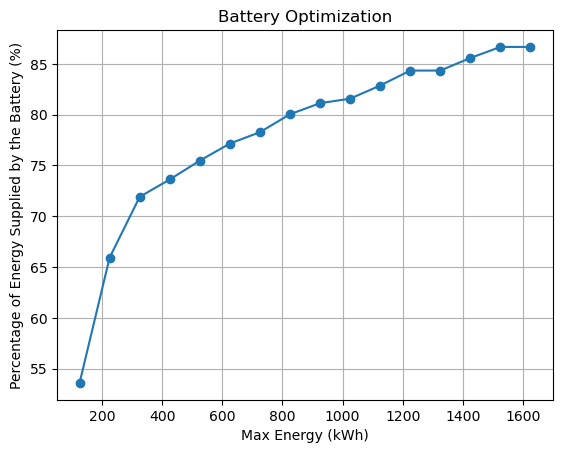

In [10]:
#Para a potencia usamos a de pico, mas para a energia Fazemos loop com vários e 
#analisamos a percentagem que se consegue abastecer a carga. Quando houver saturação esse é o ideal (não há ganho marginal)
import matplotlib.pyplot as plt
from pulp import *

# Load profile  - Vem do exercicio de clusterização para encontrar o padrão recorrente usando o DTW
load = [32.0, 31.0, 32.0, 31.0, 31.0, 31.0, 38.5, 57.0, 76.0, 121.5, 171.0, 155.0, 117.5, 92.0, 90.0, 108.0, 96.5, 88.0, 78.0, 67.0, 48.0, 39.0, 34.0, 33.0]

# We try several Energy capacities and find out which delivers the most to the load. Define the range for Max_energy
min_energy = 125
max_energy = 1700
step_energy = 100

# Lists to store the values
max_energy_values = []
percentage_values = []

# Loop through different values of Max_energy
for energy in range(min_energy, max_energy + 1, step_energy):
    # Problem Statement
    problem = LpProblem("Battery Optimization", LpMaximize)

    # Rest of your code...

    # Set the value for Max_energy
    Max_energy = energy

    Max_Power=250 

    # Problem Statement
    problem = LpProblem("Battery Optimization", LpMaximize)

    # Define variables
    hours = range(24)  # 24 hours in a day
    power_in = LpVariable.dicts("Power_in", hours, lowBound=0, upBound=Max_Power)  # Power input to the battery in each hour
    power_out = LpVariable.dicts("Power_out", hours, lowBound=0, upBound=Max_Power)  # Power output from the battery in each hour
    energy_in = LpVariable.dicts("Energy_in", hours, lowBound=0, upBound=Max_energy)  # Energy charged by the battery in each hour
    energy_out = LpVariable.dicts("Energy_out", hours, lowBound=0, upBound=Max_energy)  # Energy discharged by the battery in each hour
    soc = LpVariable.dicts("SOC", hours, lowBound=0, upBound=Max_energy)  # State of charge of the battery at the end of each hour
    charge_discharge = LpVariable.dicts("Charge_Discharge", hours, cat='Binary')  # Binary variable representing charging or discharging

    # Objective function
    problem += lpSum(energy_in[hour] for hour in hours)  # Maximize the sum of energy input

    # Constraints
    for hour in hours:
        # Energy balance constraint
        if hour == 0:
            problem += soc[hour] == energy_in[hour] - energy_out[hour]  # Battery starts the day with zero energy
        else:
            problem += soc[hour] == soc[hour-1] + energy_in[hour] - energy_out[hour]  # Energy at the end of the hour

        problem += power_in[hour] == energy_in[hour]  # Assuming 1 hour time step
        problem += power_out[hour] == energy_out[hour]  # Assuming 1 hour time step

        # Power capacity constraint
        problem += power_in[hour] <= Max_Power  # Maximum power input of 100 kW
        problem += power_out[hour] <= Max_Power  # Maximum power output of 100 kW

        # Energy capacity constraint
        problem += energy_in[hour] <= Max_energy  # Maximum energy capacity of 140 kWh
        problem += energy_out[hour] <= Max_energy  # Maximum energy capacity of 140 kWh

        # Additional constraint to prevent charging and discharging at the same time
        problem += energy_in[hour] <= charge_discharge[hour] * Max_energy
        problem += energy_out[hour] <= (1 - charge_discharge[hour]) * Max_energy

    # Add load constraints
    for hour in hours:
        problem += power_out[hour] <= load[hour]  # Power output cannot exceed the load demand

    # Add constraint for SOC to be zero at the beginning of the day
    problem += soc[0] == 0
    problem += soc[23] == 0
    
    
        # Solve the problem
    problem.solve()

    total_energy_provided = 0
    for hour in hours:
        total_energy_provided += power_out[hour].varValue

    max_energy_values.append(Max_energy)
    percentage_values.append(total_energy_provided/sum(load)*100)

# Plot the values
plt.plot(max_energy_values, percentage_values, marker='o')
plt.xlabel("Max Energy (kWh)")
plt.ylabel("Percentage of Energy Supplied by the Battery (%)")
plt.title("Battery Optimization")
plt.grid(True)
plt.show()
